# US Population EDA and Time Series

### Import our modules

In [368]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

### Import our dataset

In [369]:
full_data = pd.read_csv('POPH.csv', parse_dates=True)
full_dates_and_values = full_data.drop(columns= ['realtime_start','realtime_end'] )
pre_1981 = full_dates_and_values[ full_dates_and_values['date'] < '1981' ]
pre_1981.to_csv('population_data_pre_1981.csv', index= False)
post_1981 = full_dates_and_values[ full_dates_and_values['date'] > '1981' ]


In [370]:
pop = pd.read_csv('population_data_pre_1981.csv', index_col='date', parse_dates=True)


Let's take a quick look at our time series and see if its stationary or if we are going to have to do some work on it.

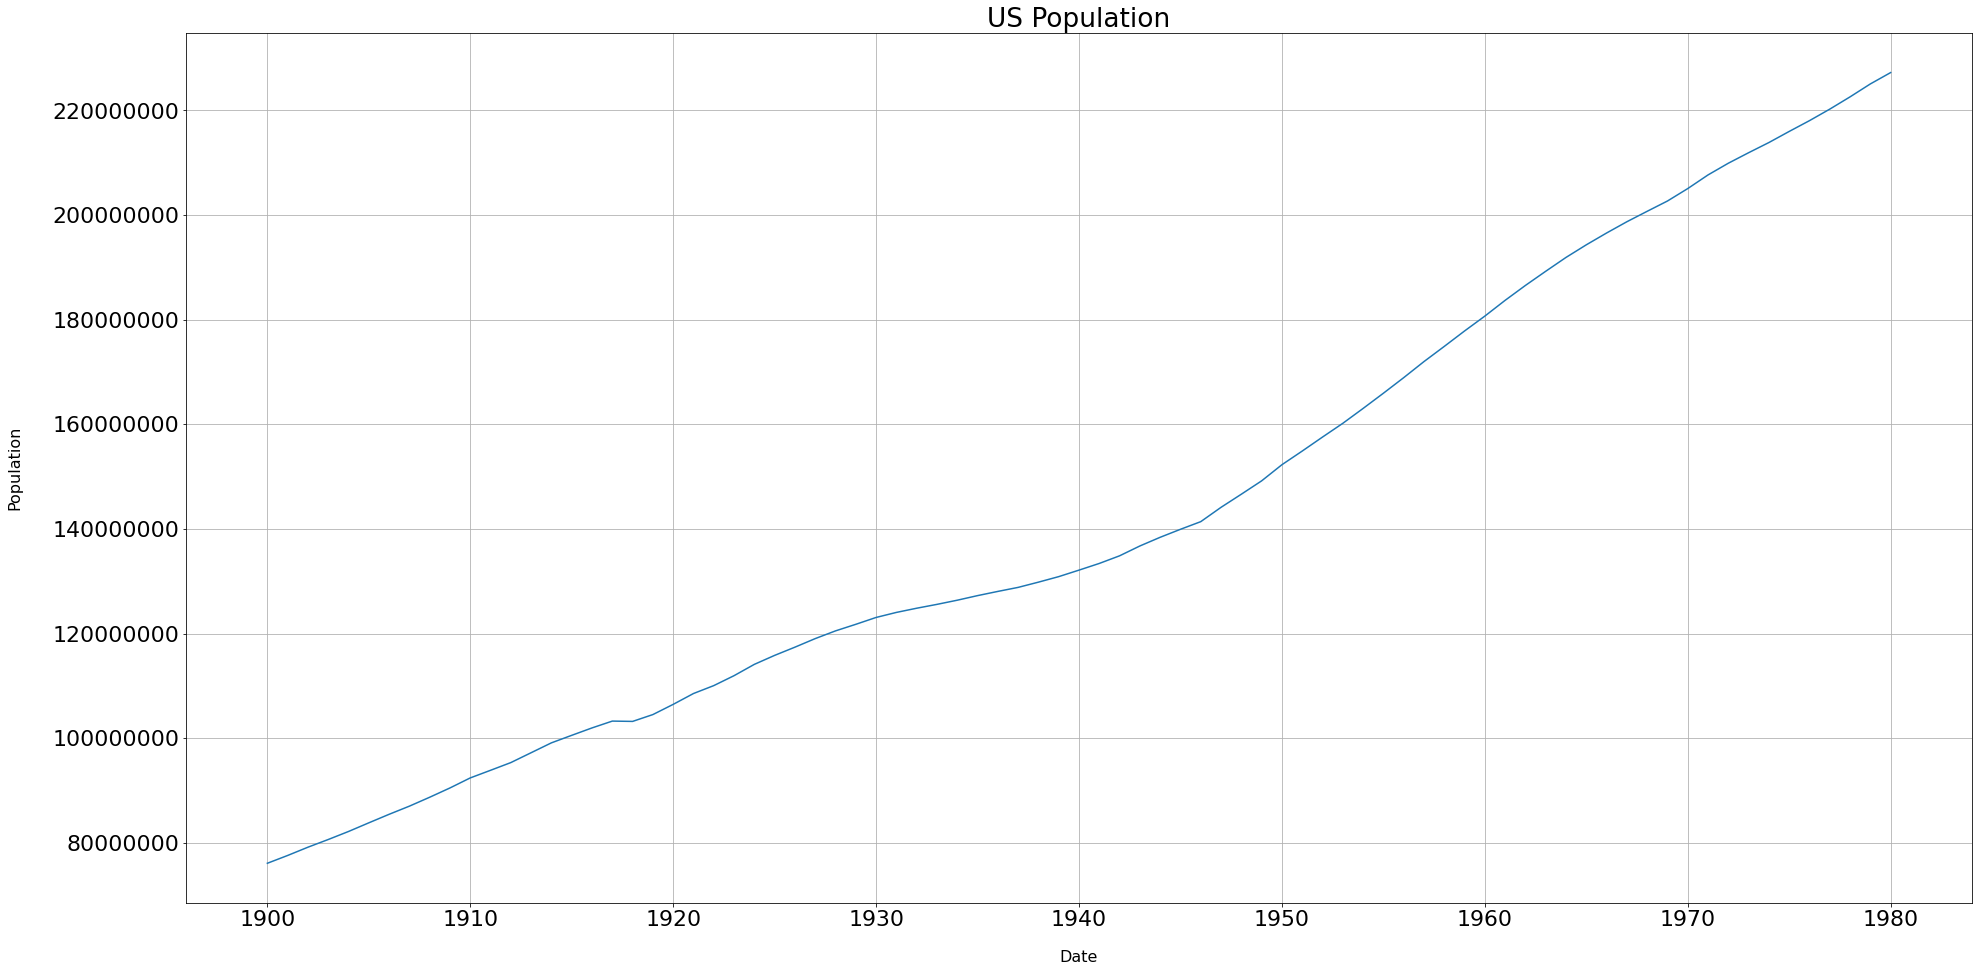

In [391]:
# Plot and show the time series on axis ax1
plt.figure(figsize=(32, 16))
plt.plot(pop)
plt.rc('axes', labelsize=16)  
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Date", labelpad= 20)
plt.ylabel('Population', labelpad= 30)
plt.title('US Population')
plt.grid()
plt.show()


Looks like our model is not stationary. We should run the adfuller test for non stionality just to see what we are working with. After that, let's try taking some differencing until our time series is stationary

In [372]:
# Run ADF test on the differenced time series
result = adfuller(pop['value'])
# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 1.2725565936842833
p-value: 0.9964507698153465


Alright, this is pretty bad and we should not ignore the blatant non stationary component of our data

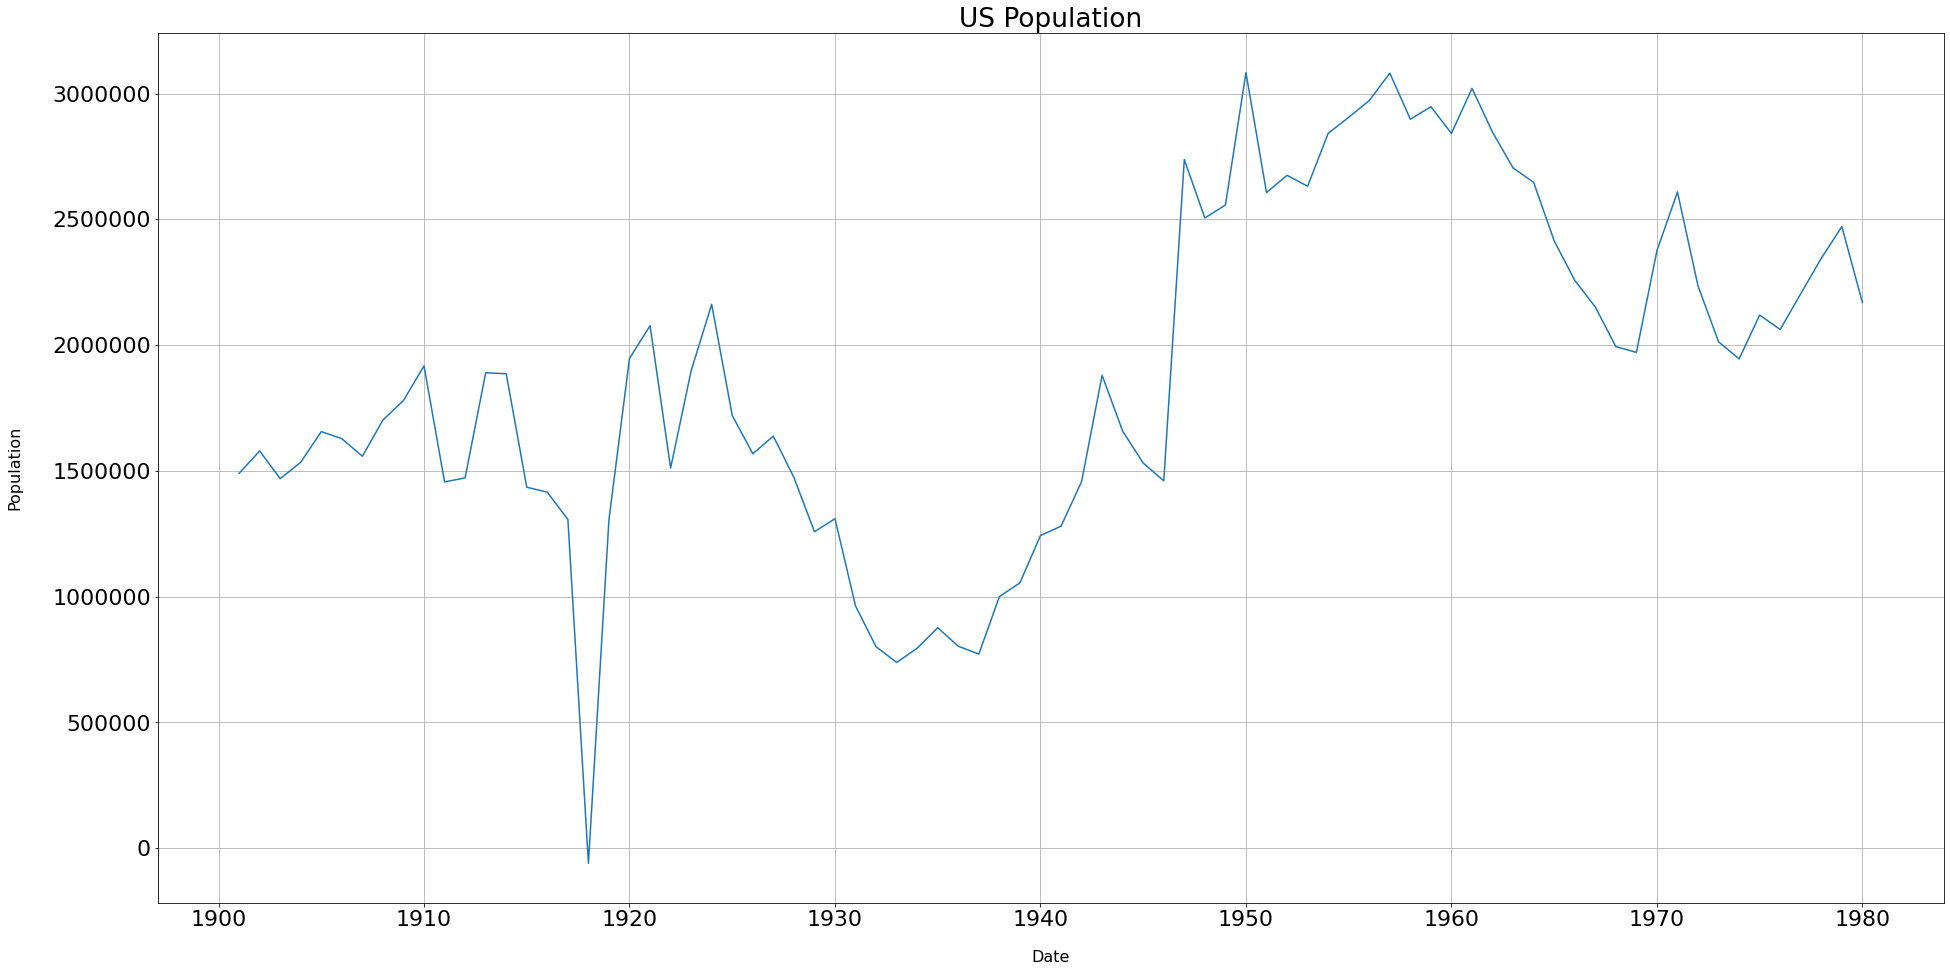

In [392]:
pop_stationary = pop.diff().dropna()

plt.figure(figsize=(32, 16))
plt.plot(pop_stationary)
plt.rc('axes', labelsize=16)  
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Date", labelpad= 20)
plt.ylabel('Population', labelpad= 30)
plt.title('US Population')
plt.grid()
plt.show()

It would appear taking one difference was not enough. Lets see what the stats tell us. If we cannot reject the null (which is that the  series is non stationary) let's try differencing again

In [374]:
# Run ADF test on the differenced time series
result = adfuller(pop_stationary['value'])


# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.3283282262251563
p-value: 0.1629942380332498


A .16 p value is not acceptable even in industry. Let's see if we can do better.

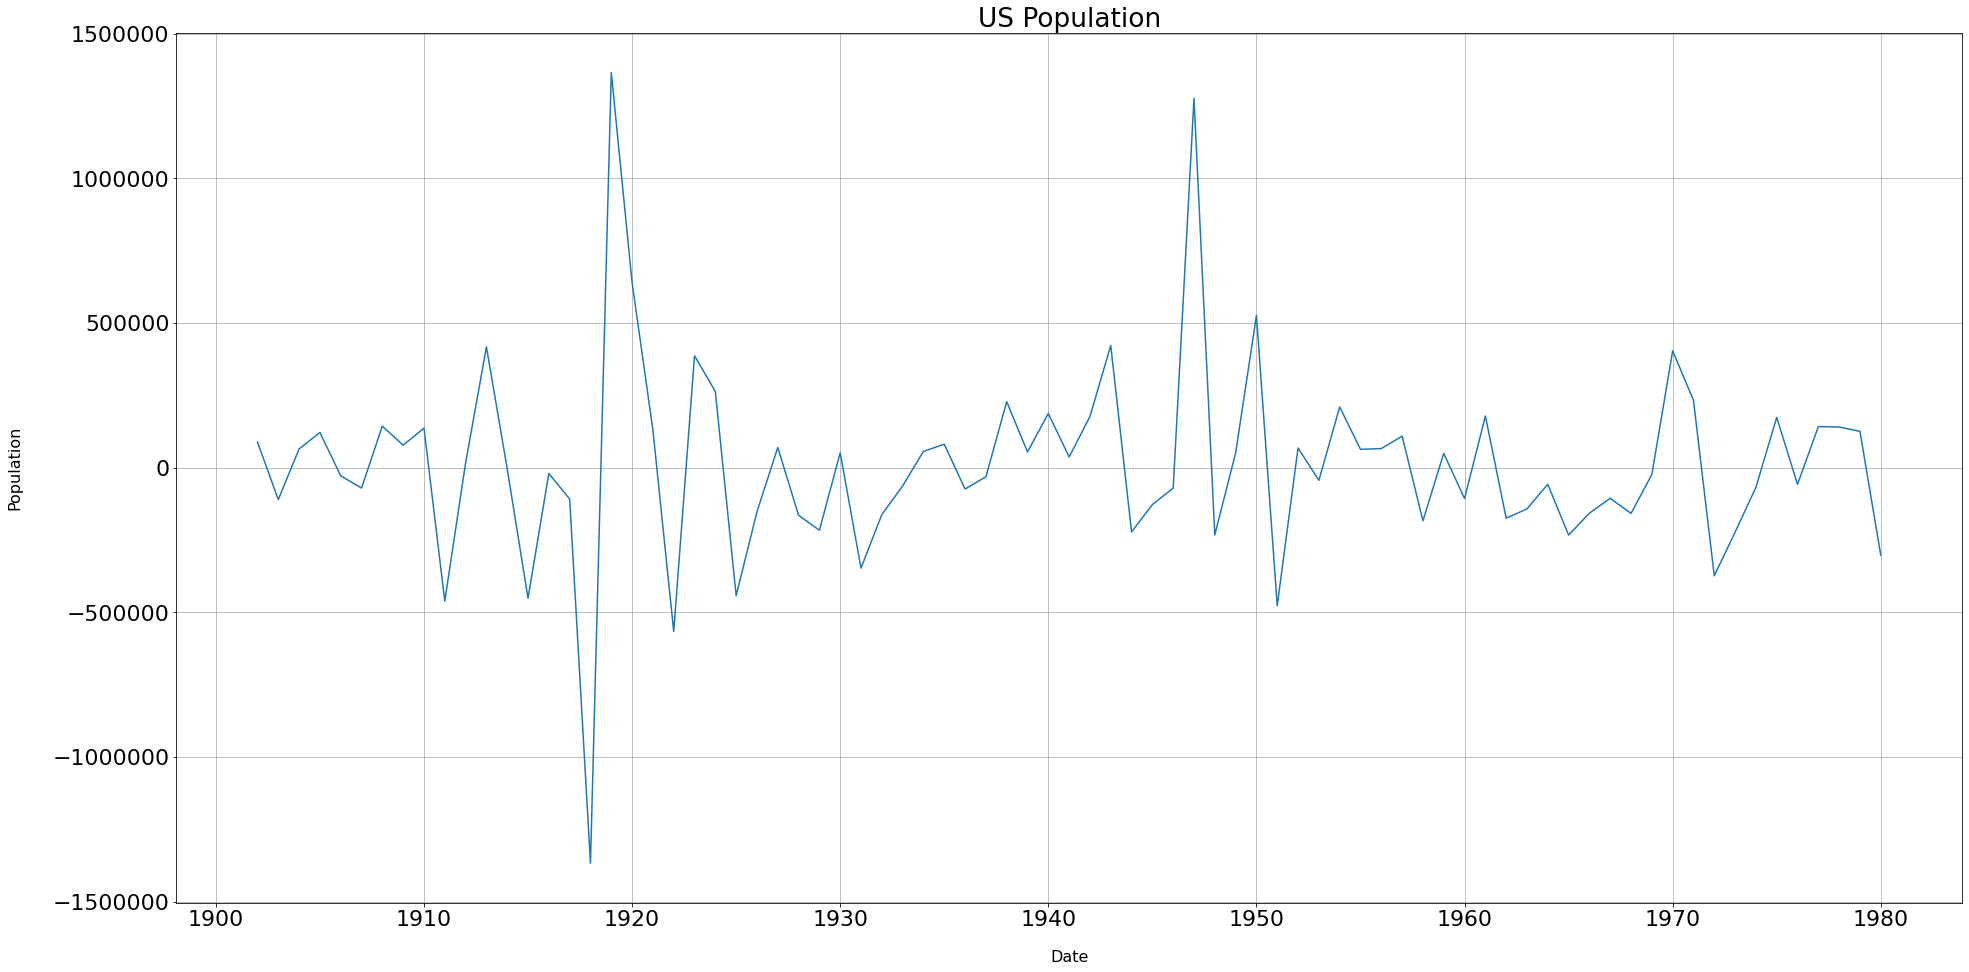

In [393]:
pop_stationary = pop.diff().diff().dropna()

plt.figure(figsize=(32, 16))
plt.plot(pop_stationary)
plt.rc('axes', labelsize=16)  
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Date", labelpad= 20)
plt.ylabel('Population', labelpad= 30)
plt.title('US Population')
plt.grid()
plt.show()



That looks much better. Let's see if we can some quantitative assurance that the time series is now stationary

In [376]:
# Run ADF test on the differenced time series
result = adfuller(pop_stationary['value'])


# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -8.572057585753425
p-value: 8.147434229187723e-14


Excellent! We can reject the null that our time series is NOT stationary and can proceed to fit an SARIMA model. Lets see if there is any seasonality to the data 

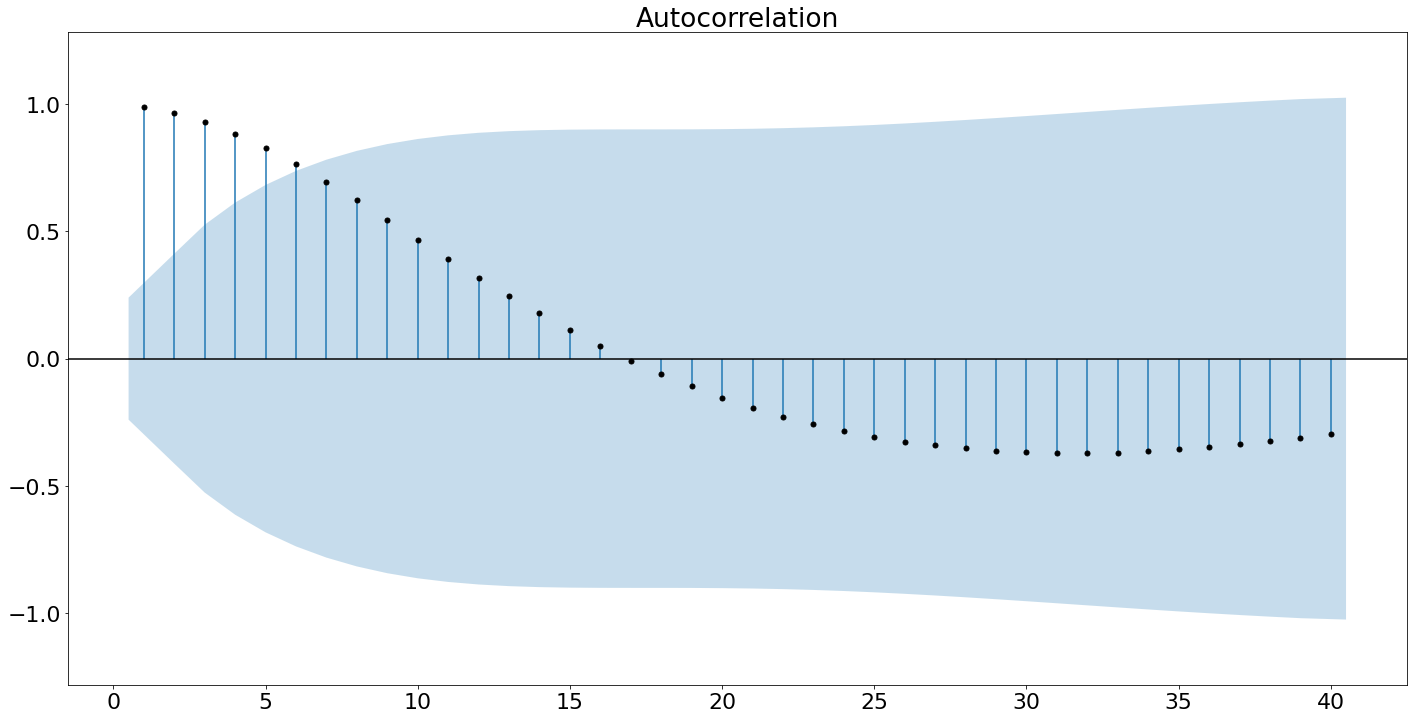

In [377]:
pop_2 = pop - pop.rolling(15).mean()

# Drop the NaN values
pop_2 = pop_2.dropna()

# Create figure and subplots
fig, ax1 = plt.subplots(figsize = (24,12))
# Plot the ACF
plot_acf(pop_2['value'], lags=40, zero=False, ax=ax1, auto_ylims=True, color = "black")

# Show figure
plt.show()

It would seem like there is no seasonality component to our data. We had expected but it does not hurt to check. 

Now lets see if we can find the p and q parameters for the AR or MA model in the ARIMA model

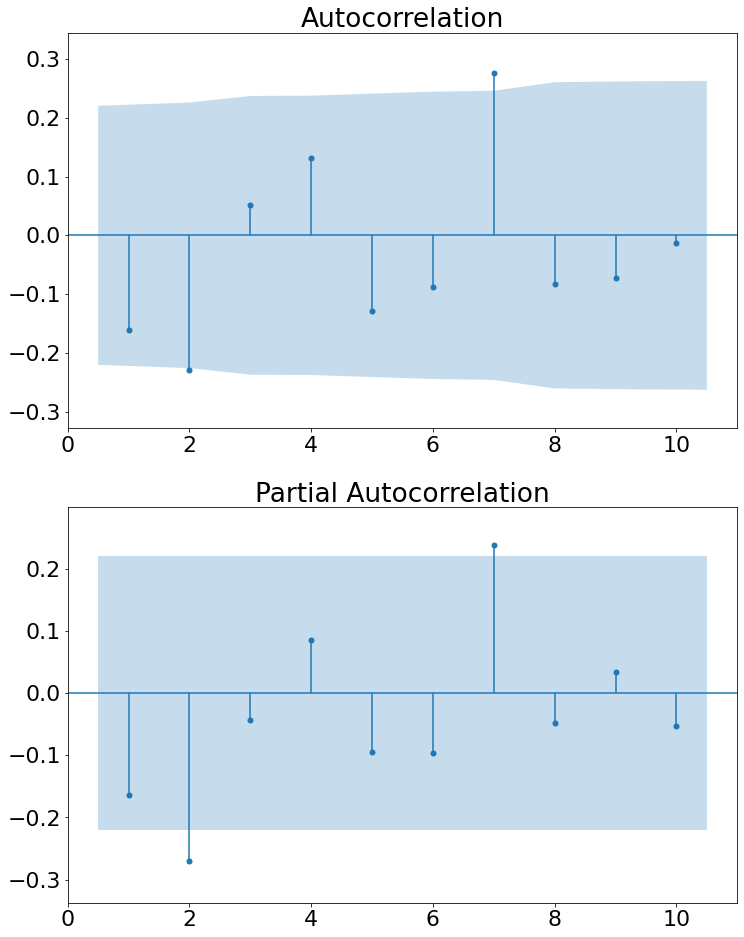

In [378]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,16))
 
# Plot the ACF of df
plot_acf( pop.diff().diff().dropna(), lags=10, zero=False, ax=ax1, auto_ylims=True)


# Plot the PACF of df
plot_pacf( pop.diff().diff().dropna(), lags=10, zero=False, ax=ax2, auto_ylims=True)

plt.show()

From our acf and pacf graph, it would appear as if neither follows the standard rules for determining coefficents. This leads me to believe we may not have a p and q value. Let's apply a brute force method just to confirm

In [379]:

# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-4
for p in range(5):
    # Loop over q values from 0-4
    for q in range(5):
        try:
            # create and fit ARMA(p,q) model
            model = SARIMAX(pop, order=(p,2,q))
            results = model.fit()
            order_aic_bic.append((p,q,results.aic, results.bic, results.mse ))
            
        except:
            order_aic_bic.append((p,q,results.aic, results.bic, results.mse))

order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC', "MSE"]) 


In [380]:
# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC', ascending = True)  )

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC', ascending = True) )

# Print order_df in order of increasing AIC
print(order_df.sort_values('MSE', ascending = True)  )

    p  q          AIC          BIC           MSE
0   0  0  2240.373227  2242.742675  1.403123e+14
1   0  1  2242.249788  2246.988683  1.401071e+14
5   1  0  2242.254673  2246.993569  1.401082e+14
6   1  1  2242.281658  2249.390001  1.366869e+14
2   0  2  2244.241491  2251.349835  1.402219e+14
10  2  0  2244.428412  2251.536755  1.402257e+14
13  2  3  2245.448096  2259.664783  1.393102e+14
7   1  2  2246.218926  2255.696718  1.402252e+14
3   0  3  2246.251692  2255.729483  1.400046e+14
15  3  0  2246.262697  2255.740489  1.400198e+14
11  2  1  2246.321289  2255.799081  1.402195e+14
20  4  0  2248.040464  2259.887703  1.397349e+14
16  3  1  2248.198268  2260.045507  1.399998e+14
12  2  2  2248.217504  2260.064743  1.404087e+14
8   1  3  2248.268254  2260.115494  1.401712e+14
4   0  4  2248.273238  2260.120477  1.397018e+14
22  4  2  2249.602168  2266.188303  1.401881e+14
21  4  1  2249.988915  2264.205602  1.397205e+14
9   1  4  2250.201961  2264.418648  1.398303e+14
17  3  2  2250.20407

It would seem that AIC and BIC both are suggesting a p = 0 and q = 0 choice. However, the MSE favors the p = 1 and q = 1 choice. This choice is in the top 5 for AIC and BIC so its worth considering it as a backup option or comparison at the revision step.

Now lets take a look at our diagostics plots to see how well the model fits to the assumptions needed to forecast accurately on our 0,2,0 model

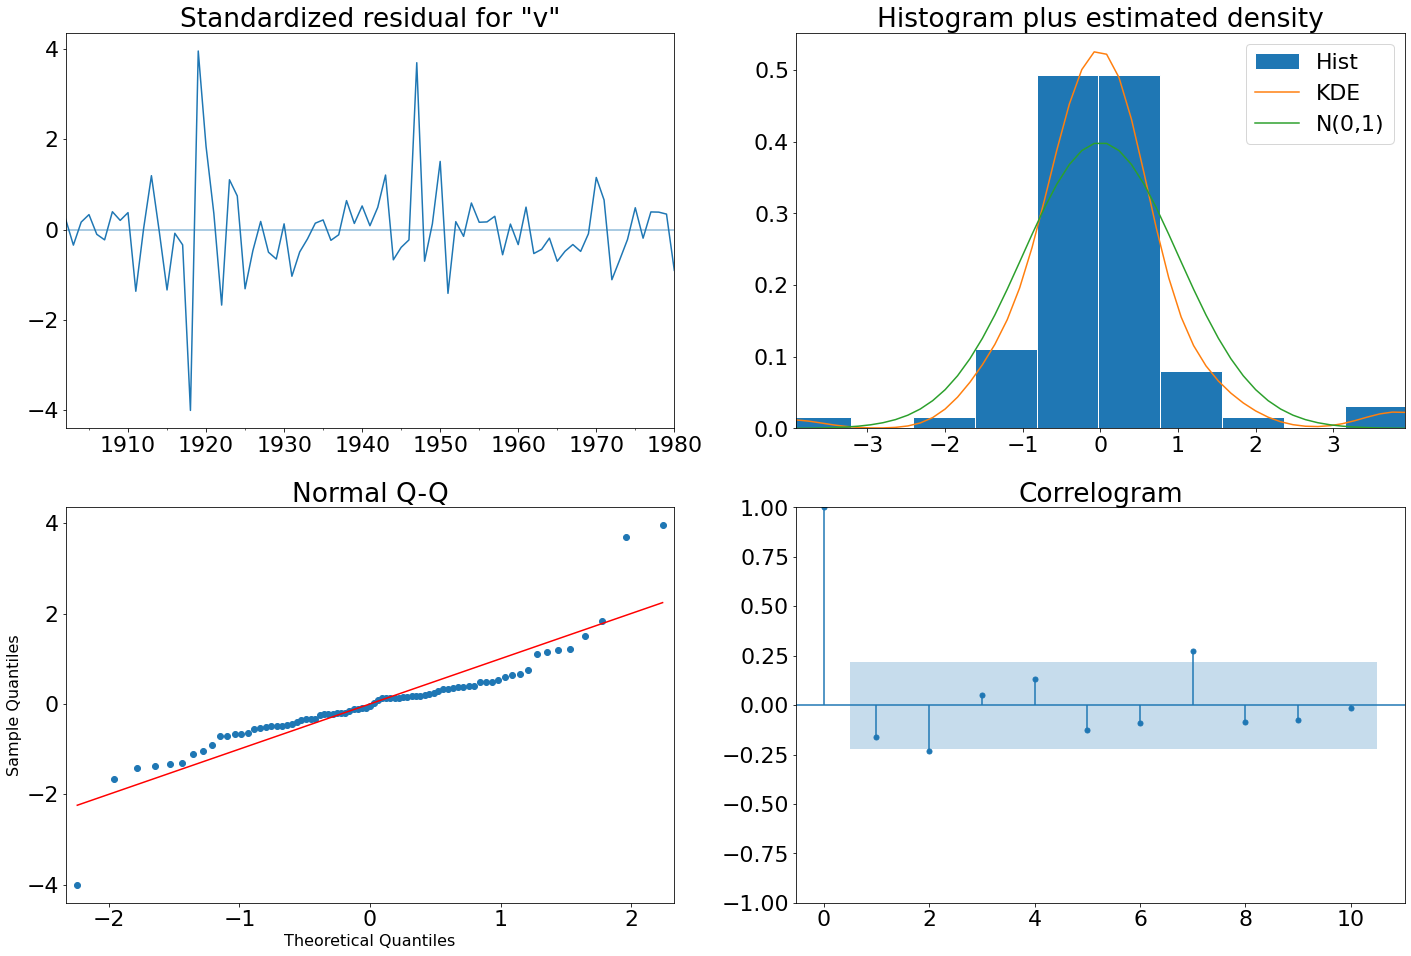

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   81
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1119.149
Date:                Sun, 12 Dec 2021   AIC                           2242.299
Time:                        16:04:52   BIC                           2247.038
Sample:                    01-01-1900   HQIC                          2244.197
                         - 01-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8597.3924   3.94e+04      0.218      0.827   -6.87e+04    8.59e+04
sigma2      1.181e+11    9.4e+09     12.573      0.000    9.97e+10    1.37e+11
Ljung-Box (L1) (Q):                   2.14   Jarque-

In [381]:
# Create and fit model
model = SARIMAX(pop, order=(0,2,0), trend='c')
results = model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics( figsize= (24,16))
plt.show()

# Print summary
print(results.summary())

Overal, it seems the model did "OK". The standardized resiudals do seem to have a bit of problem with high variance but no other discernible pattern. The histogram visual looks fairly consistent with a gaussian distribution. Normal Q-Q seems to be worst offender but the 3/4 looks okay. We will try this model out and see how it performs.

In [382]:
# Create ARIMA(0,2,0) model
arima = SARIMAX(pop, order=(0,2,0))

# Fit ARIMA model
arima_results = arima.fit()

# Make ARIMA forecast of next values and confidence intervals
forecast = arima_results.get_forecast(steps=19)
arima_value_forecast = forecast.predicted_mean
interval = forecast.conf_int()
lower_values = interval['lower value']
upper_values = interval['upper value']


1981-01-01    229393875.0
1982-01-01    231563069.0
1983-01-01    233732263.0
1984-01-01    235901457.0
1985-01-01    238070651.0
1986-01-01    240239845.0
1987-01-01    242409039.0
1988-01-01    244578233.0
1989-01-01    246747427.0
1990-01-01    248916621.0
1991-01-01    251085815.0
1992-01-01    253255009.0
1993-01-01    255424203.0
1994-01-01    257593397.0
1995-01-01    259762591.0
1996-01-01    261931785.0
1997-01-01    264100979.0
1998-01-01    266270173.0
1999-01-01    268439367.0
Freq: AS-JAN, Name: predicted_mean, dtype: float64


Now that we have our forecasted values and their respective confidence intervals, lets prep the date colums for visualizations and then plot the predicted vs actual values 

In [383]:
full_date_time_obj = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in full_dates_and_values.date]
prediction_date_time_obj = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in post_1981['date']]

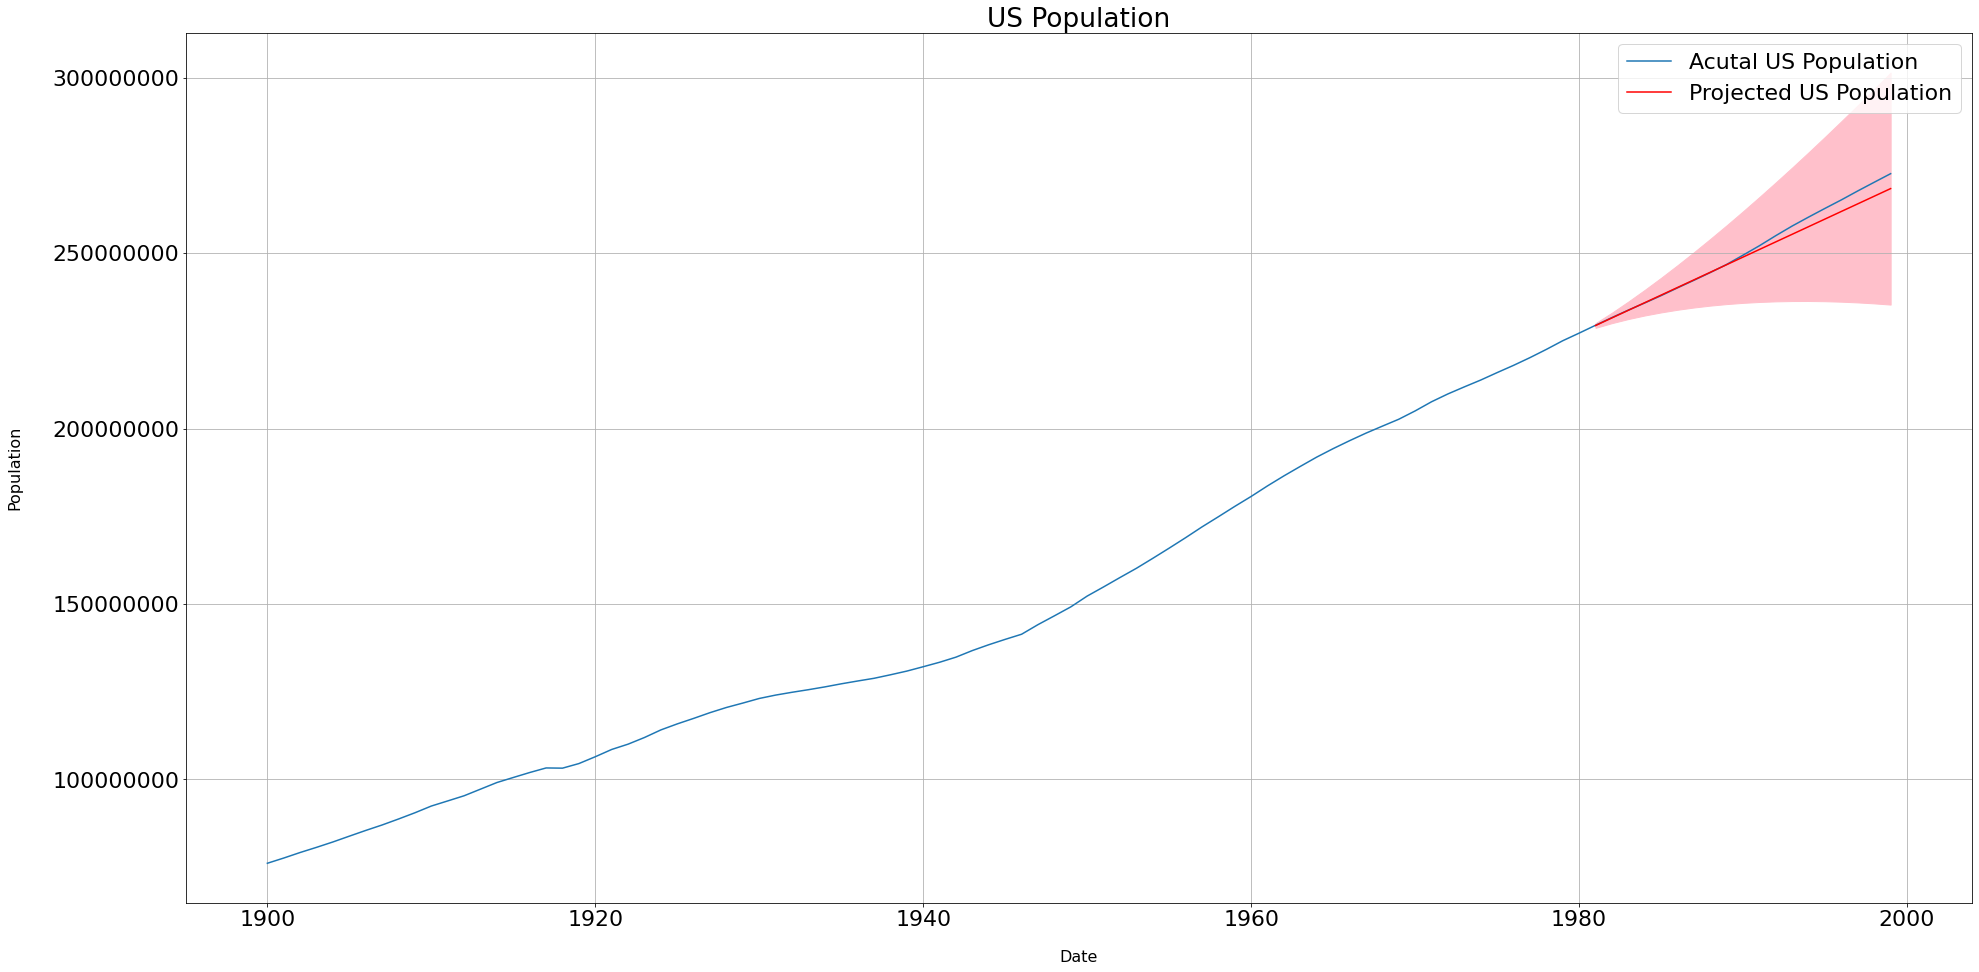

In [384]:
plt.figure(figsize=(32, 16))
plt.plot(full_date_time_obj, full_dates_and_values['value'], label = "Acutal US Population" )
plt.plot(prediction_date_time_obj, arima_value_forecast, label = 'Projected US Population', color = 'r')
plt.fill_between(prediction_date_time_obj, lower_values, upper_values, color='pink')
plt.rc('axes', labelsize=16)  
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Date", labelpad= 20)
plt.ylabel('Population', labelpad= 30)
plt.title('US Population')
plt.grid()
plt.legend()
plt.show()

Here we are! It would seem as if our model underpredicts the growth of us population midway through. Perhaps this is an issue with the model or perhaps events that occured in the late 90's caused a rapid growth in the US population that our model did not anticipate?

Let's calucate our error and see how we did and see if that other model we had in our back pocket performs any better over the same time period

Unfortunately, we cannot use a independent t-test because the samples are not normally distributed. As a result, we can only really compare the mean and standard deviations in passing but make no statically significant claims about whether or not they belong to the same distribution. 

(array([9., 1., 1., 0., 1., 1., 1., 2., 1., 2.]),
 array([  59731. ,  478902.5,  898074. , 1317245.5, 1736417. , 2155588.5,
        2574760. , 2993931.5, 3413103. , 3832274.5, 4251446. ]),
 <BarContainer object of 10 artists>)

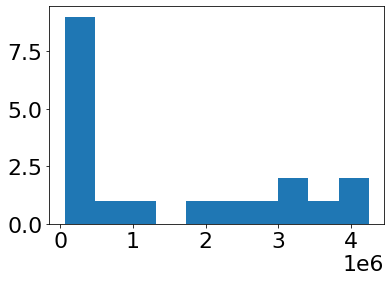

In [385]:
error_020 = (abs(post_1981['value'] - arima_value_forecast.values)).to_list()
error_020
plt.hist(error_020)

In [386]:
# Create ARIMA(0,2,0) model
arima_a = SARIMAX(pop, order=(1,2,1))

# Fit ARIMA model
arima_results_a = arima_a.fit()

# Make ARIMA forecast of next values and confidence intervals
forecast_a = arima_results_a.get_forecast(steps=19)
arima_value_forecast_a = forecast_a.predicted_mean
interval_a = forecast_a.conf_int()
lower_values_a = interval_a['lower value']
upper_values_a = interval_a['upper value']

(array([10.,  0.,  1.,  0.,  1.,  1.,  1.,  2.,  1.,  2.]),
 array([  33736.5994851 ,  391972.93623416,  750209.27298323,
        1108445.60973229, 1466681.94648136, 1824918.28323042,
        2183154.61997949, 2541390.95672855, 2899627.29347762,
        3257863.63022668, 3616099.96697575]),
 <BarContainer object of 10 artists>)

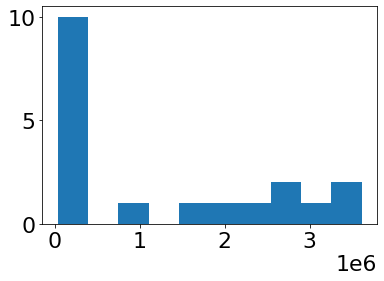

In [387]:
import statistics
error_121 = (abs(post_1981['value'] - arima_value_forecast_a.values)).to_list()
plt.hist(error_121)

In [388]:
from statistics import pstdev, mean

print(f'The average error of the ARIMA(0,2,0) is {int(mean(error_020))} with a standard deviation of {int(pstdev(error_020))}')
print(f'The average error of the ARIMA(1,2,1) is {int(mean(error_121))} with a standard deviation of {int(pstdev(error_121))}')


The average error of the ARIMA(0,2,0) is 1450823 with a standard deviation of 1543893
The average error of the ARIMA(1,2,1) is 1257433 with a standard deviation of 1301222


We have a lower average error and lower standard deviations with our ARIMA(1,2,1). This leads to believe we should at least plot it and see how it comapares relative to the other model. We will plot the two models and the actual values but just focusing in on the years after 1980

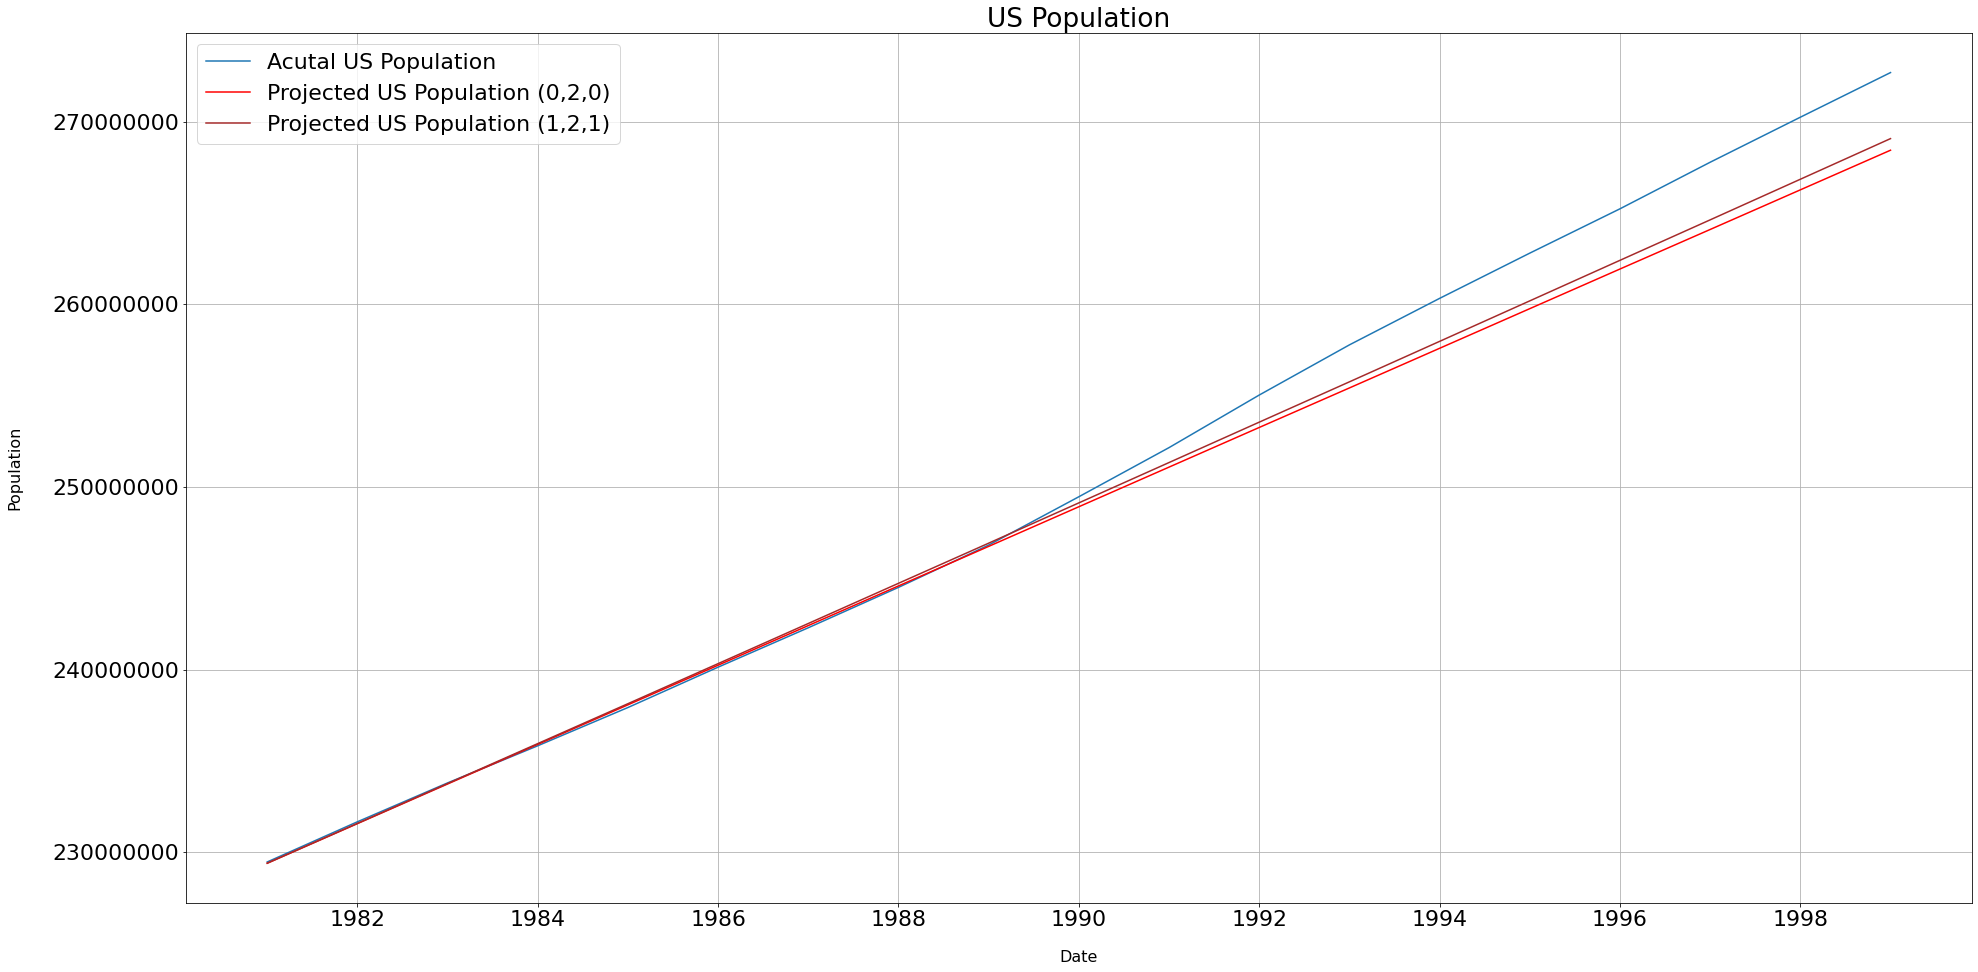

In [389]:
plt.figure(figsize=(32, 16))
plt.plot(prediction_date_time_obj, post_1981['value'], label = "Acutal US Population" )
plt.plot(prediction_date_time_obj, arima_value_forecast, label = 'Projected US Population (0,2,0)', color = 'r')
plt.plot(prediction_date_time_obj, arima_value_forecast_a, label = 'Projected US Population (1,2,1)', color = 'brown'  )
plt.rc('axes', labelsize=16)  
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Date", labelpad= 20)
plt.ylabel('Population', labelpad= 30)
plt.title('US Population')
plt.grid()
plt.legend()
plt.show()

It would seem like our 1,2,1 model predicts a little higher values overal. You can see from the years of 1985 to 1989, our 1,2,1 model over estimated the us population compared the actual and the 0,2,0 model. As such, I think I will proceed with the 1,2,1 and put it into proudction to predict us populations going forward